In [1]:
# Kristiaan Hector | Varun Aggarwal | Aaron Etienne

from __future__ import print_function, division
from io import BufferedReader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import classification_report, confusion_matrix
import pickle

start_time = time.time()

plt.ion()

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = "weed_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                           transform=data_transforms[x])
                 for x in ["train", "val", "test"]}
temp = image_datasets["train"]
# print("-----------------------------", os.path.join(data_dir, "train"))  
print("-----------------------------", temp[0])       
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                              shuffle=True, num_workers=4)
              for x in ["train", "val", "test"]}



dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}
class_names = image_datasets["train"].classes

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device = torch.device("cpu")

----------------------------- (tensor([[[-1.4158, -1.3302, -1.3473,  ..., -0.4739, -0.4739, -0.4568],
         [-1.4500, -1.5699, -1.5699,  ..., -0.4568, -0.4739, -0.4226],
         [-1.3987, -1.3815, -1.1589,  ..., -0.4226, -0.3883, -0.3369],
         ...,
         [-0.2513, -0.5253, -0.9705,  ..., -1.6213, -1.6555, -1.5357],
         [-0.2684, -0.4739, -0.9534,  ..., -1.3302, -1.3987, -1.4672],
         [-0.3027, -0.3883, -0.8164,  ..., -1.2445, -1.2617, -1.2788]],

        [[-1.3704, -1.2829, -1.3004,  ...,  0.3803,  0.3803,  0.3978],
         [-1.4580, -1.5455, -1.5455,  ...,  0.3978,  0.3803,  0.4328],
         [-1.4405, -1.3880, -1.1604,  ...,  0.4328,  0.4678,  0.5203],
         ...,
         [ 0.3277,  0.0476, -0.2675,  ..., -1.7031, -1.6681, -1.4580],
         [ 0.2927,  0.0651, -0.3375,  ..., -1.5805, -1.5805, -1.5980],
         [ 0.0126,  0.1176, -0.2675,  ..., -1.4930, -1.5105, -1.5280]],

        [[-1.2467, -1.1421, -1.1596,  ..., -0.4973, -0.5147, -0.4798],
         [-1.3

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)
        
        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()  # set model to training mode
            else:
                model.eval()  # set model to evaulate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Interate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training mode
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(
                phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == "val":
                val_loss.append(epoch_loss)
                val_acc.append(float(epoch_acc.to("cpu").numpy()))
            else:
                train_loss.append(epoch_loss)
                train_acc.append(float(epoch_acc.to("cpu").numpy()))
        
        print()
        
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(
        time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    with open('./accuracy.pkl', 'wb') as f:
        pickle.dump({
            "training": train_acc,
            "validation": val_acc
        }, f)
    with open('./loss.pkl', 'wb') as f:
        pickle.dump({
            "training": train_loss,
            "validation": val_loss
        }, f)

    torch.save(model, 'weed_data.pth')

    return model

In [14]:
# Load a pretrained model and reset final fully connected layer

# for vgg16
# model_ft = models.vgg16(pretrained=True)
# num_ftrs = model_ft.classifier[0].out_features

# for resnet 18
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# for inception
# model_ft = models.inception_v3(pretrained=True)
# num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
from torchsummary import summary
summary(model_ft, input_size=(3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]          36,864
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
             ReLU-10           [-1, 64, 75, 75]               0
       BasicBlock-11           [-1, 64, 75, 75]               0
           Conv2d-12           [-1, 64, 75, 75]          36,864
      BatchNorm2d-13           [-1, 64, 75, 75]             128
             ReLU-14           [-1, 64,

In [6]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


/home/salazar/anaconda3/envs/resnet/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


KeyboardInterrupt: 

In [16]:
# Confusion matrix
def print_confusion_matrix(model):
    pred = []
    true = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = np.reshape(preds, (len(preds), 1))
            labels = np.reshape(labels, (len(preds), 1))
            for i in range(len(preds)):
                pred.append(class_names[int(preds[i])])
                true.append(class_names[int(labels[i])])
    with open('./preds.pkl', 'wb') as f:
        pickle.dump({
            "true": true,
            "pred": pred,
            "classes": class_names
        }, f)

    
    print(classification_report(true, pred, class_names))
    return confusion_matrix(true, pred, class_names)

cm = print_confusion_matrix(model_ft)
# print(cm)

              precision    recall  f1-score   support

   cocklebur       1.00      0.94      0.97        17
     foxtail       1.00      0.86      0.92        14
     pigweed       0.94      0.97      0.96        34
     ragweed       0.84      0.91      0.87        23

    accuracy                           0.93        88
   macro avg       0.95      0.92      0.93        88
weighted avg       0.94      0.93      0.93        88



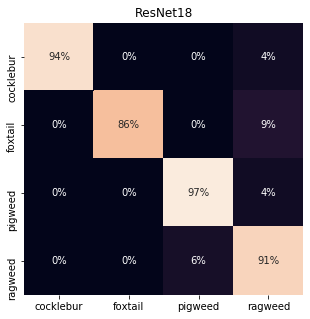

In [17]:
# for plots et al.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

row_sums = cm.sum(axis=1)
cm = cm / row_sums

df_cm = pd.DataFrame(cm, index = ['cocklebur','foxtail','pigweed','ragweed'], columns = ['cocklebur','foxtail','pigweed','ragweed'])
# print(df_cm)

# flights = df_cm.pivot("month", "year", "passengers")

plt.figure(figsize = (5,5))
plt.title('ResNet18')
sn.heatmap(df_cm, annot=True, fmt='0.0%', cbar=False)
plt.savefig('ResNet18.png')